# Embedding graphs with covariates
> Some experiments on a real dataset of interest using CASE and MASE
 
- toc: true
- badges: true
- categories: [pedigo, graspologic]
- hide: false
- search_exclude: false

## Preliminaries

In [1]:
# collapse
import os
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from umap import UMAP

from graspologic.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed, selectSVD
from graspologic.plot import pairplot, screeplot
from graspologic.utils import get_lcc, pass_to_ranks, to_laplace
from src.io import savefig
from src.visualization import adjplot, matrixplot, set_theme

set_theme()

FNAME = os.path.basename(__file__)[:-3]


def stashfig(name, **kws):
    savefig(name, foldername=FNAME, save_on=True, **kws)



In [2]:
# collapse
data_dir = Path("maggot_models/data/raw/OneDrive_1_10-21-2020")
covariate_loc = data_dir / "product_node_embedding.csv"
edges_loc = data_dir / "product_edges.csv"
category_loc = data_dir / "partition_mapping.csv"

covariate_df = pd.read_csv(covariate_loc, index_col=0, header=None).sort_index()
meta_df = pd.read_csv(category_loc, index_col=0).sort_index()
assert (covariate_df.index == meta_df.index).all()

edges_df = pd.read_csv(edges_loc).sort_index()
g = nx.from_pandas_edgelist(edges_df, edge_attr="weight", create_using=nx.DiGraph)
adj = nx.to_numpy_array(g, nodelist=meta_df.index)


In [3]:
# collapse
print(f"Number of vertices (original): {len(adj)}")

make_lcc = False
if make_lcc:
    adj, keep_inds = get_lcc(adj, return_inds=True)
    print(f"Number of vertices (lcc): {len(adj)}")
else:
    # HACK need to throw out some entire classes here that have very few members
    y = meta_df["cat_id"]
    unique, inv, count = np.unique(y, return_inverse=True, return_counts=True)
    low_count = count < 5
    print(f"Removing categories with fewer than 5 examples: {unique[low_count]}")
    keep_inds = ~np.isin(inv, unique[low_count])
    adj = adj[np.ix_(keep_inds, keep_inds)]
    print(f"Number of vertices (small classes removed): {len(adj)}")
meta_df = meta_df.iloc[keep_inds]
covariate_df = covariate_df.iloc[keep_inds]
Y = covariate_df.values


Number of vertices (original): 1035
Removing categories with fewer than 5 examples: [3 4 6 7]
Number of vertices (small classes removed): 1029


In [4]:
# collapse
colors = sns.color_palette("deep")
palette = dict(zip(np.unique(meta_df["cat_id"]), colors))


## Adjacency matrix (sorted by category)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fee60d49150>,
 <matplotlib.axes._axes.Axes at 0x7fee61106410>)

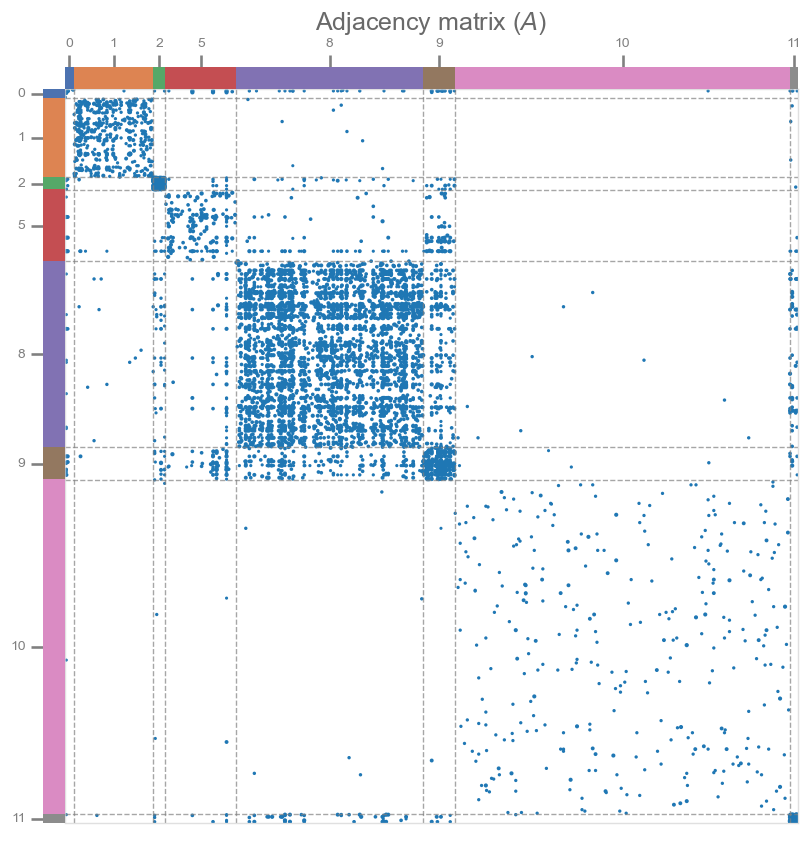

In [5]:
# collapse
adjplot(
    pass_to_ranks(adj),
    plot_type="scattermap",
    meta=meta_df,
    colors="cat_id",
    sort_class="cat_id",
    palette=palette,
    title=r"Adjacency matrix ($A$)",
)

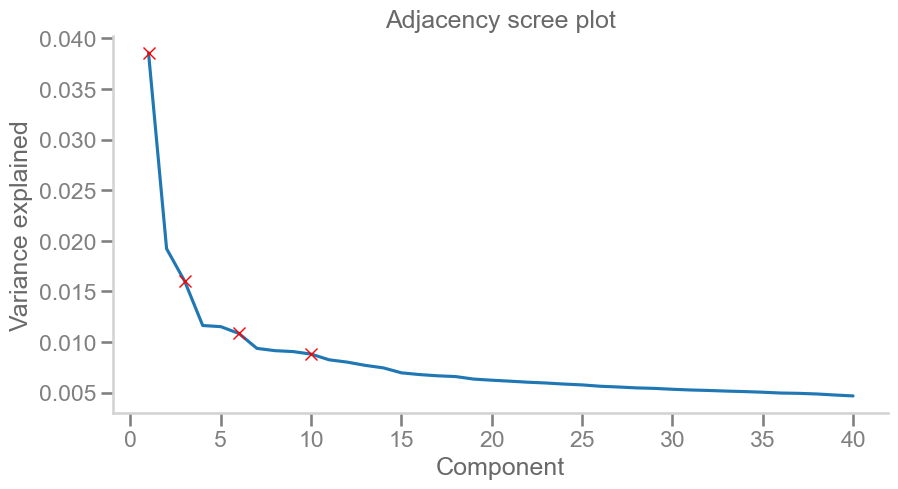

In [6]:
ax = screeplot(
    pass_to_ranks(adj), show_first=40, cumulative=False, title="Adjacency scree plot"
)

## Covariates (sorted by category)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fee6278fd90>,
 <matplotlib.axes._axes.Axes at 0x7fee62783e10>)

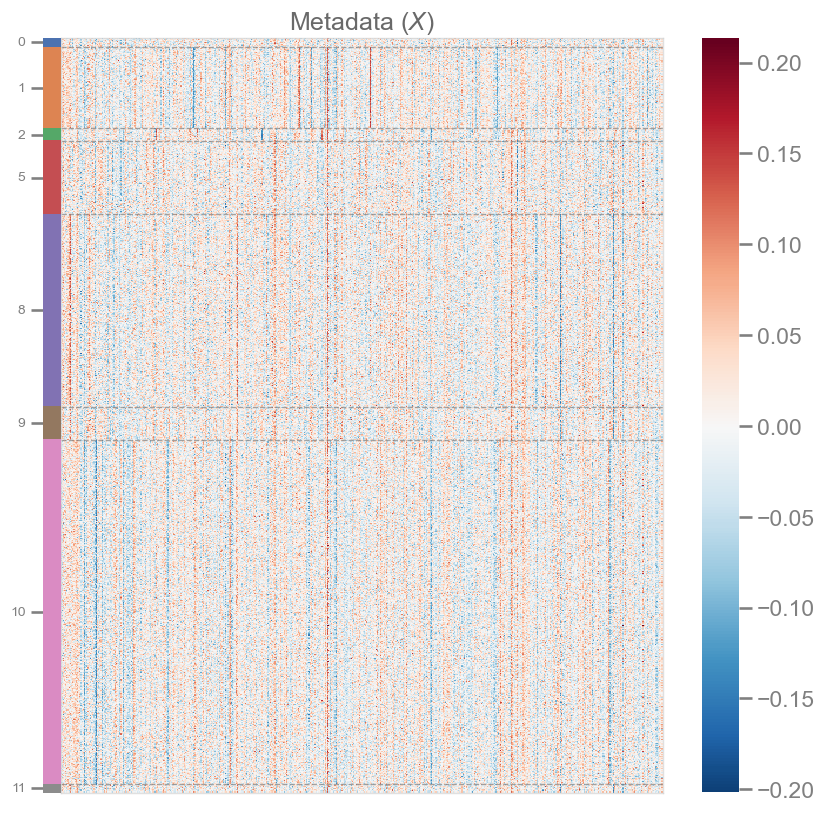

In [7]:
# collapse
matrixplot(
    Y,
    row_meta=meta_df,
    row_colors="cat_id",
    row_sort_class="cat_id",
    row_palette=palette,
    title=r"Metadata ($X$)",
)

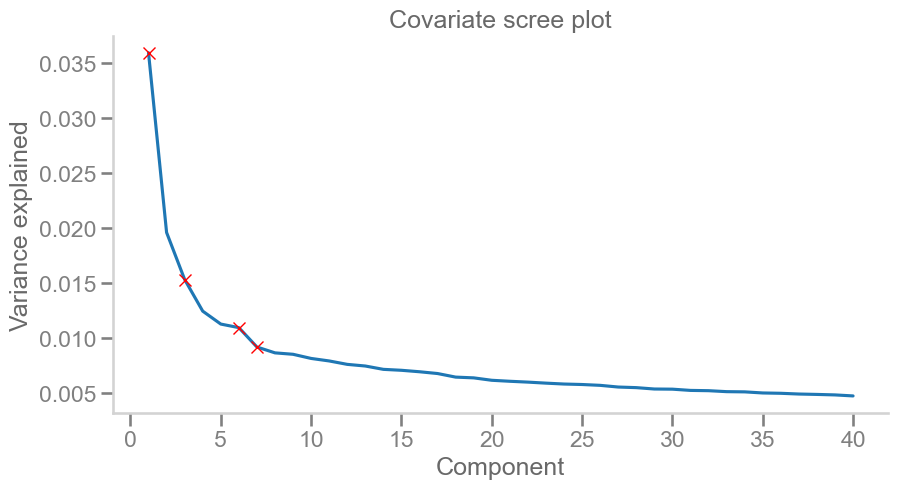

In [8]:
# collapse
ax = screeplot(Y, show_first=40, cumulative=False, title="Covariate scree plot")

## R-LSE

/Users/bpedigo/JHU_code/maggot_models/graspologic/graspologic/embed/lse.py:161: UserWarning:

Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.get_lcc``.

Saved figure to maggot_models/notebooks/outs/194.2-BDP-not-a-brain/figs/pairplot-rlse.png


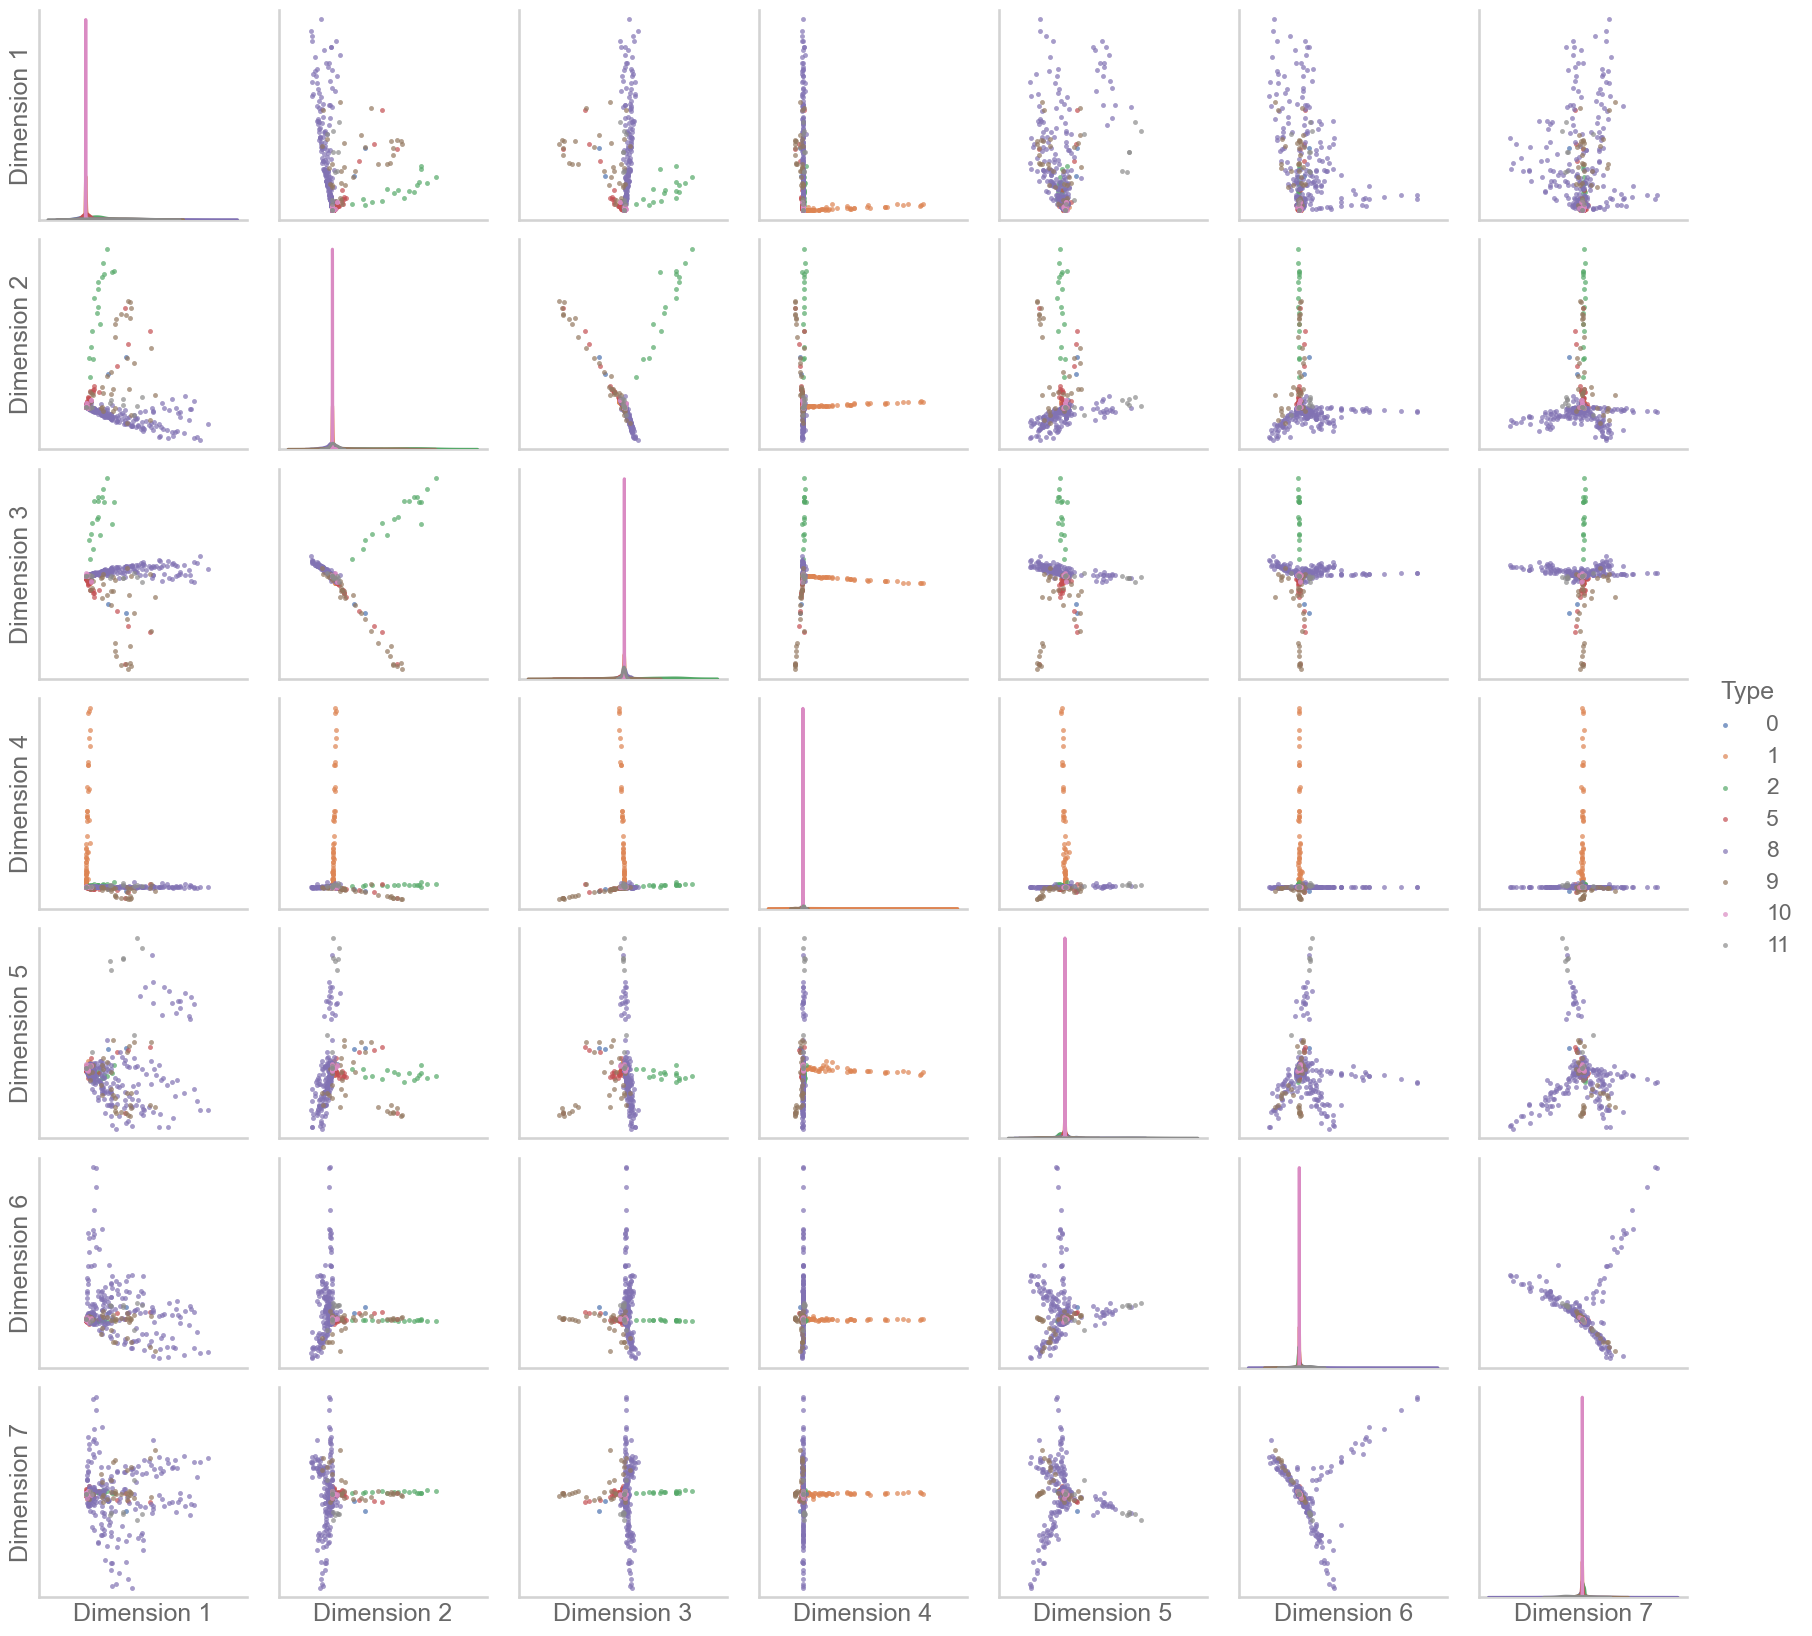

In [9]:
# collapse
lse = LaplacianSpectralEmbed(form="R-DAD")
embedding = lse.fit_transform(pass_to_ranks(adj))
pairplot(embedding[0], labels=meta_df["cat_id"].values, palette=palette)
stashfig("pairplot-rlse")

Saved figure to maggot_models/notebooks/outs/194.2-BDP-not-a-brain/figs/umap-rlse.png


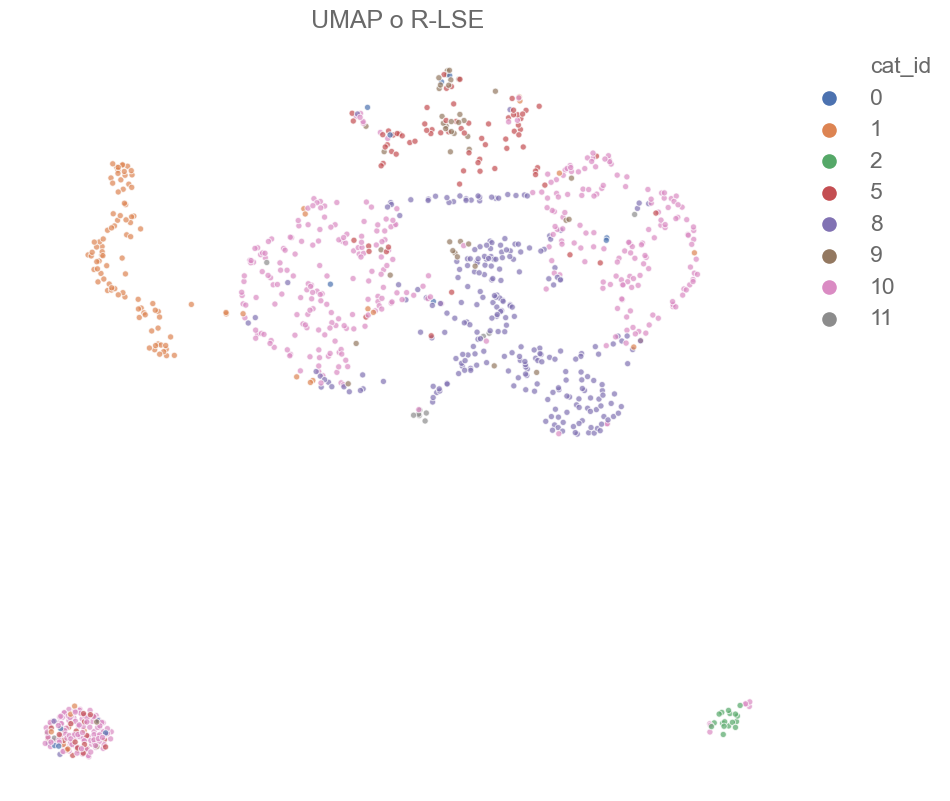

In [10]:
# collapse
concat_embedding = np.concatenate(embedding, axis=1)

umapper = UMAP(min_dist=0.7, metric="cosine")
umap_embedding = umapper.fit_transform(concat_embedding)

plot_df = pd.DataFrame(
    data=umap_embedding,
    columns=[f"umap_{i}" for i in range(umap_embedding.shape[1])],
    index=meta_df.index,
)
plot_df["cat_id"] = meta_df["cat_id"]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(
    data=plot_df,
    x="umap_0",
    y="umap_1",
    s=20,
    alpha=0.7,
    hue="cat_id",
    palette=palette,
    ax=ax,
)
ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax.set_title("UMAP o R-LSE")
ax.axis("off")
stashfig("umap-rlse")

## CASE
 Running CASE with a few different parameters

In [11]:
# collapse
L = to_laplace(pass_to_ranks(adj), form="R-DAD")  # D_{tau}^{-1/2} A D_{tau}^{-1/2}
Y = covariate_df.values


def build_case_matrix(L, Y, alpha, method="assort"):
    if method == "assort":
        L_case = L + alpha * Y @ Y.T
    elif method == "nonassort":
        L_case = L @ L.T + alpha * Y @ Y.T
    elif method == "cca":  # doesn't make sense here, I don't thinks
        L_case = L @ Y
    return L_case


def fit_case(L, Y, alpha, method="assort", n_components=None):
    L_case = build_case_matrix(L, Y, alpha, method=method)
    case_embedder = AdjacencySpectralEmbed(
        n_components=n_components, check_lcc=False, diag_aug=False, concat=True
    )
    case_embedding = case_embedder.fit_transform(L_case)
    return case_embedding


n_components = 8
alphas = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
methods = ["assort", "nonassort"]
case_by_params = {}
umap_by_params = {}
for method in methods:
    for alpha in alphas:
        case_embedding = fit_case(L, Y, alpha, method=method, n_components=n_components)
        umapper = UMAP(min_dist=0.7, metric="cosine")
        umap_embedding = umapper.fit_transform(case_embedding)
        case_by_params[(method, alpha)] = case_embedding
        umap_by_params[(method, alpha)] = umap_embedding


 Plot each of the embeddings

Saved figure to maggot_models/notebooks/outs/194.2-BDP-not-a-brain/figs/casc-umaps.png


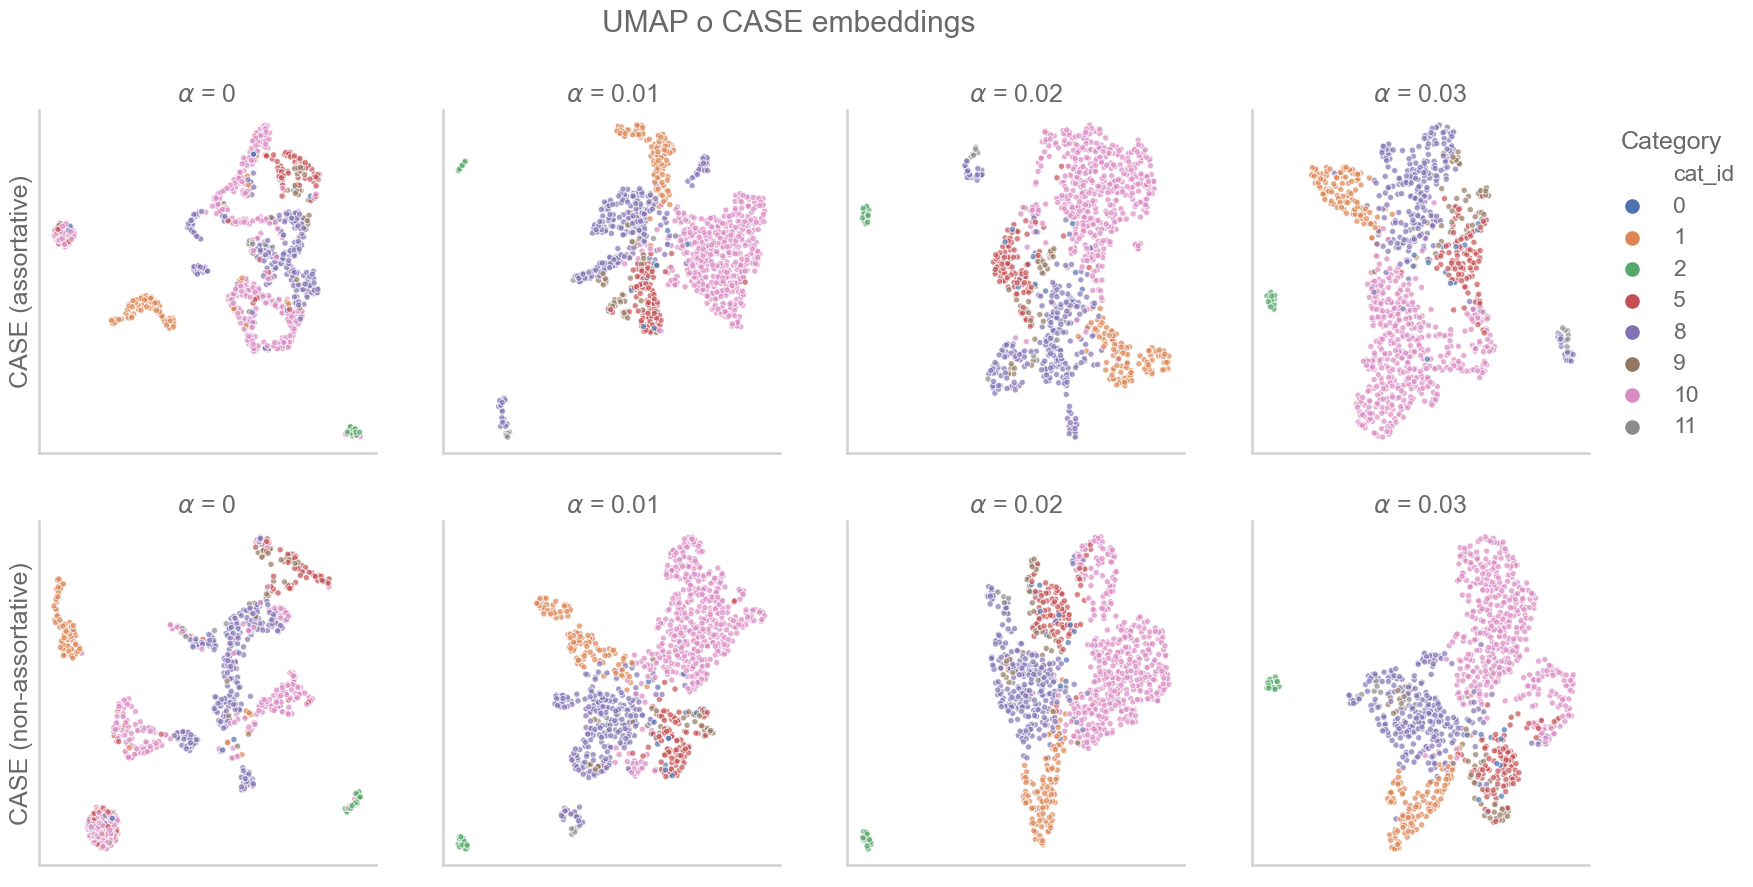

In [12]:
# collapse
fig, axs = plt.subplots(
    len(methods), len(alphas[:4]), figsize=5 * np.array([len(alphas[:4]), len(methods)])
)
for i, method in enumerate(methods):
    for j, alpha in enumerate(alphas[:4]):
        ax = axs[i, j]
        umap_embedding = umap_by_params[(method, alpha)]
        plot_df = pd.DataFrame(
            data=umap_embedding,
            columns=[f"umap_{c}" for c in range(umap_embedding.shape[1])],
            index=meta_df.index,
        )
        plot_df["cat_id"] = meta_df["cat_id"]
        sns.scatterplot(
            data=plot_df,
            x="umap_0",
            y="umap_1",
            s=20,
            alpha=0.7,
            hue="cat_id",
            palette="deep",
            ax=ax,
        )
        ax.get_legend().remove()

        # ax.axis("off")
        ax.set(xticks=[], yticks=[], ylabel="", xlabel="")
        ax.set_title(r"$\alpha$ = " + f"{alpha}")

axs[0, -1].legend(bbox_to_anchor=(1, 1), loc="upper left", title="Category")
axs[0, 0].set_ylabel("CASE (assortative)")
axs[1, 0].set_ylabel("CASE (non-assortative)")
fig.suptitle("UMAP o CASE embeddings")
stashfig("casc-umaps")


## MASE
 Running MASE (here I'm using the Laplacian and the covariates as the two inputs)

In [13]:
# collapse
Y = covariate_df.values
n_components = 6  # TODO picked this just roughly looking at screeplots
U_Y, D_Y, Vt_Y = selectSVD(Y @ Y.T, n_components=n_components)
U_L, D_L, Vt_L = selectSVD(L, n_components=n_components)
covariate_embedding = U_Y

concatenated_latent = np.concatenate((U_L, U_Y), axis=1)
U_joint, D_joint, Vt_joint = selectSVD(concatenated_latent, n_components=8)
mase_embedding = U_joint

## A simple classifier on the embeddings
 Here I just do a simple 5-nearest-neighbors classifier. Note that I haven't done any
 tuning of the classifier (like how many neighbors to use or distances other than
 Euclidean) or the dimension of the embedding itself.

 In the experiment below, I am doing cross validation, and not treating the out-of-graph
 nodes any differently (i.e. they are just mixed in for the cross validation).

In [14]:
# collapse
classifier = KNeighborsClassifier(n_neighbors=5)
y = meta_df["cat_id"].values

rows = []
for method in methods:
    for alpha in alphas:
        X = case_by_params[(method, alpha)]
        cval_scores = cross_val_score(classifier, X, y=y)
        for score in cval_scores:
            rows.append({"score": score, "alpha": alpha, "method": method})

X = mase_embedding
cval_scores = cross_val_score(classifier, X, y)
for score in cval_scores:
    rows.append({"score": score, "alpha": alpha + 0.01, "method": "MASE"})

results = pd.DataFrame(rows)


Saved figure to maggot_models/notebooks/outs/194.2-BDP-not-a-brain/figs/knn-lcc=False.png


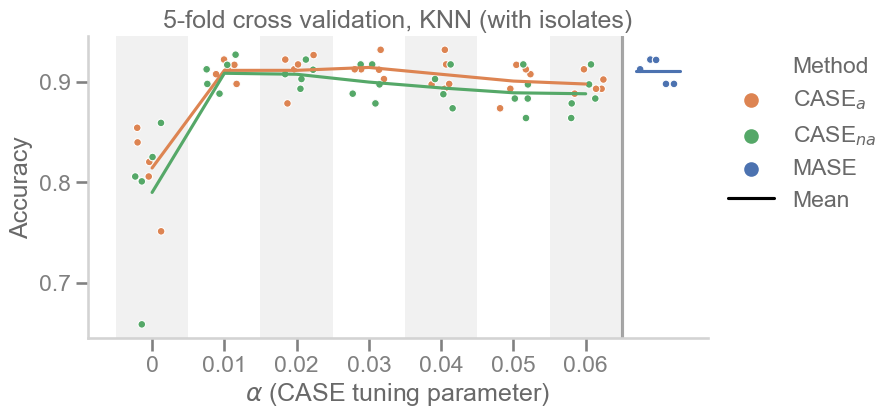

In [15]:
# collapse
x_range = np.array(alphas)
x_half_bin = 0.5 * (x_range[1] - x_range[0])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
results["jitter_alpha"] = results["alpha"] + np.random.uniform(
    -0.0025, 0.0025, size=len(results)
)
method_palette = dict(zip(np.unique(results["method"]), colors))
sns.lineplot(
    x="alpha",
    hue="method",
    y="score",
    data=results,
    ax=ax,
    ci=None,
    palette=method_palette,
)
sns.scatterplot(
    x="jitter_alpha",
    hue="method",
    y="score",
    data=results,
    ax=ax,
    palette=method_palette,
    s=30,
)
ax.set(
    ylabel="Accuracy",
    xlabel=r"$\alpha$ (CASE tuning parameter)",
    title="5-fold cross validation, KNN (with isolates)",
)
ax.xaxis.set_major_locator(plt.FixedLocator(alphas))
ax.xaxis.set_major_formatter(plt.FixedFormatter(alphas))
ax.axvline(0.065, color="grey", alpha=0.7)
mean_mase = results[results["method"] == "MASE"]["score"].mean()
ax.plot(
    [0.067, 0.073],
    [mean_mase, mean_mase],
    color=method_palette["MASE"],
)

handles, labels = ax.get_legend_handles_labels()
handles = handles[4:]
labels = labels[4:]
labels[0] = "Method"
labels[1] = r"CASE$_{a}$"
labels[2] = r"CASE$_{na}$"
handles.append(Line2D([0], [0], color="black"))
labels.append("Mean")
ax.get_legend().remove()
ax.legend(
    bbox_to_anchor=(
        1,
        1,
    ),
    loc="upper left",
    handles=handles,
    labels=labels,
)
for i, x in enumerate(x_range):
    if i % 2 == 0:
        ax.axvspan(
            x - x_half_bin,
            x + x_half_bin,
            color="lightgrey",
            alpha=0.3,
            linewidth=0,
            zorder=-1,
        )
stashfig(f"knn-lcc={make_lcc}")


## Using only the nodes with graph signal as training data
 Here I just pick one of the parameter sets for the CASE embedding from above, as well
 as the MASE embedding and the embedding we get for just the covariates alone. Then I
 use all in-graph nodes as training data, and ask how well they predict for the
 out-of-graph nodes.

In [16]:
# collapse
_, lcc_inds = get_lcc(adj, return_inds=True)
not_lcc_inds = np.setdiff1d(np.arange(len(adj)), lcc_inds)

y = meta_df["cat_id"].values
y_train = y[lcc_inds]
y_test = y[not_lcc_inds]

# just pick one CASE embedding
method = "assort"
alpha = 0.02
case_embedding = case_by_params[(method, alpha)]


def classify_out_of_graph(X):
    classifier = KNeighborsClassifier(n_neighbors=5)

    X_train = X[lcc_inds]
    X_test = X[not_lcc_inds]

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    score = accuracy_score(y_test, y_pred)

    return score, y_pred


def plot_out_of_graph(embedding, score, incorrect, method=""):
    incorrect = y_test != y_pred

    umapper = UMAP(
        n_neighbors=10, min_dist=0.8, metric="cosine", negative_sample_rate=30
    )
    umap_embedding = umapper.fit_transform(embedding)

    plot_df = pd.DataFrame(
        data=umap_embedding,
        columns=[f"umap_{c}" for c in range(umap_embedding.shape[1])],
        index=meta_df.index,
    )
    plot_df["cat_id"] = meta_df["cat_id"]
    plot_df["in_lcc"] = False
    plot_df.loc[plot_df.index[lcc_inds], "in_lcc"] = True
    plot_df["correct"] = True
    plot_df.loc[plot_df.index[not_lcc_inds[incorrect]], "correct"] = False

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.scatterplot(
        data=plot_df[plot_df["in_lcc"]],
        x="umap_0",
        y="umap_1",
        s=20,
        alpha=0.2,
        hue="cat_id",
        palette=palette,
        ax=ax,
    )
    markers = dict(zip([True, False], ["o", "X"]))
    sns.scatterplot(
        data=plot_df[~plot_df["in_lcc"]],
        x="umap_0",
        y="umap_1",
        s=30,
        alpha=0.9,
        hue="cat_id",
        palette=palette,
        style="correct",
        markers=markers,
        ax=ax,
    )
    ax.get_legend().remove()

    correct_line = Line2D(
        [0], [0], color="black", lw=0, marker="o", mew=0, markersize=7
    )
    incorrect_line = Line2D(
        [0], [0], color="black", lw=0, marker="X", mew=0, markersize=7
    )
    lines = [correct_line, incorrect_line]
    labels = ["Correct", "Incorrect"]
    ax.legend(lines, labels)

    ax.axis("off")
    ax.set_title(f"{method}, predictions on isolates: accuracy {score:.2f}")
    return fig, ax



Saved figure to maggot_models/notebooks/outs/194.2-BDP-not-a-brain/figs/case-isolate-predictions-umap.png


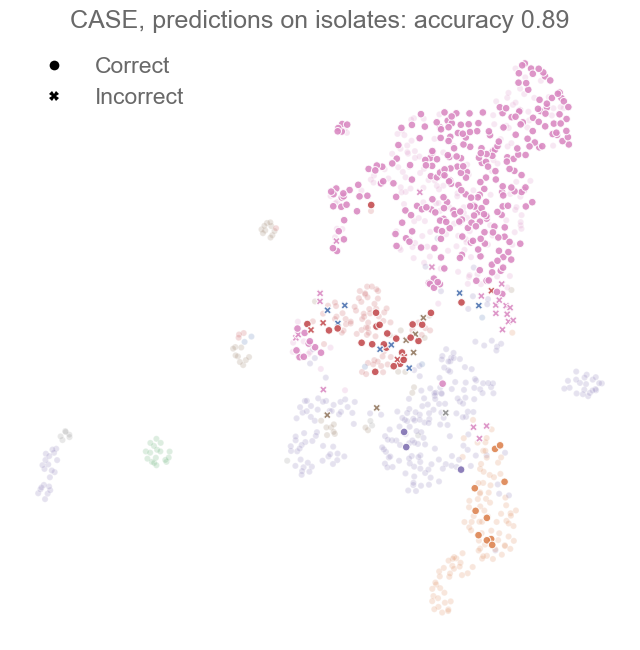

In [17]:
score, y_pred = classify_out_of_graph(case_embedding)
plot_out_of_graph(case_embedding, score, y_pred, method="CASE")
stashfig("case-isolate-predictions-umap")


Saved figure to maggot_models/notebooks/outs/194.2-BDP-not-a-brain/figs/mase-isolate-predictions-umap.png


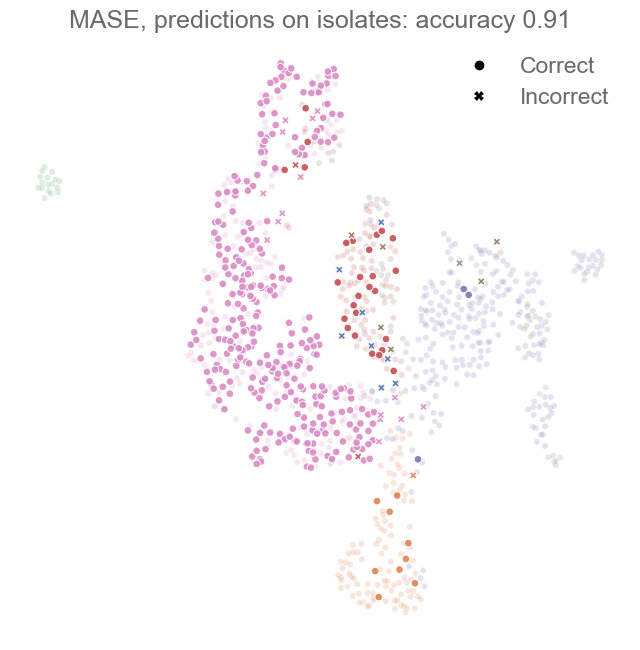

In [18]:
score, y_pred = classify_out_of_graph(mase_embedding)
plot_out_of_graph(mase_embedding, score, y_pred, method="MASE")
stashfig("mase-isolate-predictions-umap")


Saved figure to maggot_models/notebooks/outs/194.2-BDP-not-a-brain/figs/covariates-isolate-predictions-umap.png


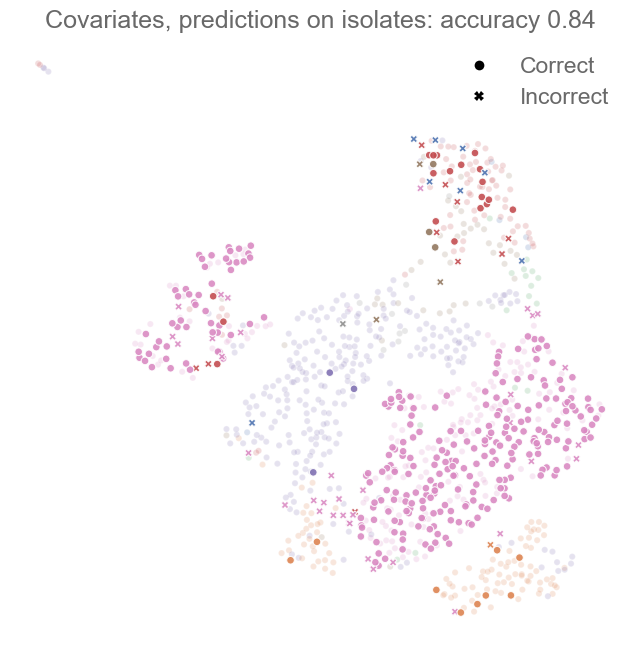

In [19]:
score, y_pred = classify_out_of_graph(U_Y)
plot_out_of_graph(U_Y, score, y_pred, method="Covariates")
stashfig("covariates-isolate-predictions-umap")